In [97]:
import arviz as az
import os.path as op
from tqdm.contrib.itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Distance to RNP
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import get_fake_data, extract_intercept_gamma
cm = 1/2.54  # centimeters in inches

palette = sns.color_palette()[6:]
order = ['Low activation', 'High activation']
bids_folder = '/data/ds-risk'

In [134]:
def load(model_label, session, bids_folder='/data/ds-risk', roi=None):
    df = get_data(model_label, session, bids_folder, roi=roi)
    model = build_model(model_label, df, session, bids_folder, roi=roi)
    idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_roi-{roi}_trace.netcdf')

    return df, model, idata

def get_hdi(x):
    return tuple(az.hdi(x.values))


rois = ['dmidbrain', 'vtav2', 'sncv2', 'meynert', 'lc'][1:]

# rois = ['vtav2', 'sncv2', 'lc']

# Simplest model

In [133]:
rnps = []
gammas = []

for roi in rois:
    df, model, idata = load('probit_subcortical_response1', '7t2', roi=roi)
    intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
    rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
    rnp = rnp[(rnp['rnp'] > 0.0) & (rnp['rnp'] < 1.0)]
    rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

    gamma = gamma.stack([-2, -1])

    rnps.append(rnp)
    gammas.append(gamma)

100%|██████████| 30/30 [00:01<00:00, 24.57it/s]


FileNotFoundError: [Errno 2] No such file or directory: b'/data/ds-risk/derivatives/cogmodels/model-probit_subcortical_response1_ses-7t2_roi-dmidbrain_trace.netcdf'

In [110]:
idata.posterior['x'].mean()

<xarray.DataArray 'x' ()>
array(1.84708086)

In [100]:
rnp = pd.concat(rnps, keys=rois, names=['roi'])
gamma = pd.concat(gammas, keys=rois, names=['roi'])

In [75]:
tmp = rnp.unstack(['median_split_subcortical_response', 'roi'])['rnp']

tmp =(tmp['Low activation'] > tmp['High activation']).mean()

tmp.apply(lambda x: np.min((x, 1-x)))

roi
vtav2      0.49825
sncv2      0.13025
meynert    0.40600
lc         0.49325
dtype: float64

In [76]:
tmp = gamma.unstack(['median_split_subcortical_response', 'roi'])['gamma']

tmp = (tmp['Low activation'] > tmp['High activation']).mean()

tmp.apply(lambda x: np.min((x, 1-x)))

roi
vtav2      0.11250
sncv2      0.12450
meynert    0.23675
lc         0.07575
dtype: float64

In [77]:
rnp_1 = rnp.groupby(['roi', 'median_split_subcortical_response']).apply(lambda x: pd.Series(get_hdi(x)[0], index=['low', 'up'])).round(4)* 100
rnp_2 = rnp.groupby(['roi', 'median_split_subcortical_response']).mean().round(4) * 100
rnp_1.join(rnp_2)[['rnp', 'low', 'up']]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  return tuple(az.hdi(x.values))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  return tuple(az.hdi(x.values))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  return tuple(az.hdi(x.values))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future relea

rnp    low     up
roi     median_split_subcortical_response                     
lc      High activation                    47.88  40.96  54.94
        Low activation                     47.92  40.08  55.38
meynert High activation                    48.25  40.89  55.74
        Low activation                     47.99  40.80  55.22
sncv2   High activation                    48.55  41.28  55.90
        Low activation                     47.33  39.63  55.19
vtav2   High activation                    48.16  41.23  55.66
        Low activation                     48.17  40.46  56.01

In [78]:
gamma_1 = gamma.groupby(['roi', 'median_split_subcortical_response']).apply(lambda x: pd.Series(get_hdi(x)[0], index=['low', 'up'])).round(2)
gamma_2 = gamma.groupby(['roi', 'median_split_subcortical_response']).mean().round(2)
gamma_1.join(gamma_2)[['gamma', 'low', 'up']]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  return tuple(az.hdi(x.values))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  return tuple(az.hdi(x.values))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  return tuple(az.hdi(x.values))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future relea

gamma   low    up
roi     median_split_subcortical_response                   
lc      High activation                     1.97  1.64  2.30
        Low activation                      1.80  1.49  2.14
meynert High activation                     1.85  1.53  2.18
        Low activation                      1.93  1.62  2.26
sncv2   High activation                     1.95  1.64  2.29
        Low activation                      1.82  1.48  2.14
vtav2   High activation                     1.96  1.64  2.28
        Low activation                      1.82  1.49  2.14

# Simple model (order x pupil split)

In [176]:
rois = ['vtav2', 'sncv2', 'lc', 'meynert']

In [177]:
rnps = []
gammas = []

for roi in rois:
    df, model, idata = load('probit_subcortical_response2.pca', '7t2', roi=roi)
    intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
    rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
    rnp = rnp[(rnp['rnp'] > 0.0) & (rnp['rnp'] < 1.0)]
    rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

    gamma = gamma.stack([-2, -1])

    rnps.append(rnp)
    gammas.append(gamma)

100%|██████████| 30/30 [00:02<00:00, 11.50it/s]


Running with PCA!


100%|██████████| 30/30 [00:01<00:00, 25.88it/s]


Running with PCA!


100%|██████████| 30/30 [00:01<00:00, 28.54it/s]


Running with PCA!


100%|██████████| 30/30 [00:00<00:00, 30.20it/s]


Running with PCA!


In [178]:
rnp = pd.concat(rnps, keys=rois, names=['roi'])
gamma = pd.concat(gammas, keys=rois, names=['roi'])

In [181]:
rnp.groupby(['roi', 'risky_first', 'median_split_subcortical_response']).mean()

rnp
roi     risky_first median_split_subcortical_response          
lc      False       High activation                    0.495432
                    Low activation                     0.514748
        True        High activation                    0.468943
                    Low activation                     0.430616
meynert False       High activation                    0.511035
                    Low activation                     0.503801
        True        High activation                    0.452276
                    Low activation                     0.460277
sncv2   False       High activation                    0.495225
                    Low activation                     0.515638
        True        High activation                    0.455120
                    Low activation                     0.451489
vtav2   False       High activation                    0.499755
                    Low activation                     0.508114
        True        High activation                    0.447707
                    Low activation                     0.454928

In [194]:
rnp.groupby(['roi', 'risky_first', 'median_split_subcortical_response'])['rnp'].apply(lambda x: pd.Series(get_hdi(x), index=pd.Index(['lower', 'upper'])).T).unstack(-1)

lower     upper
roi     risky_first median_split_subcortical_response                    
lc      False       High activation                    0.423862  0.566443
                    Low activation                     0.450873  0.585338
        True        High activation                    0.389073  0.543686
                    Low activation                     0.314045  0.534489
meynert False       High activation                    0.441781  0.584250
                    Low activation                     0.425855  0.577582
        True        High activation                    0.361607  0.545049
                    Low activation                     0.365182  0.552968
sncv2   False       High activation                    0.426183  0.559657
                    Low activation                     0.434615  0.592493
        True        High activation                    0.367004  0.544607
                    Low activation                     0.360310  0.551685
vtav2   False       High activation                    0.431606  0.568143
                    Low activation                     0.434914  0.583059
        True        High activation                    0.358617  0.539287
                    Low activation                     0.352993  0.537173

lc
0.08825000000000005


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.051
0.01849999999999996
meynert


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.2915
0.31125
0.2375
sncv2


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.08099999999999996
0.41375
0.12624999999999997
vtav2


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.28425
0.3355
0.48275


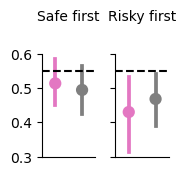

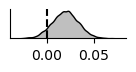

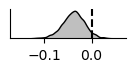

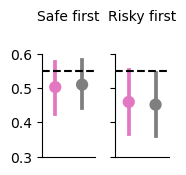

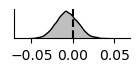

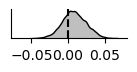

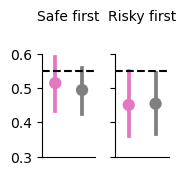

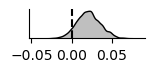

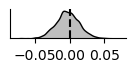

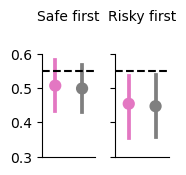

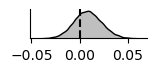

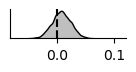

In [166]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Subcortical response'] = rnp.index.get_level_values('median_split_subcortical_response')#.map({True:'Large', False:'Small'})


for roi, r in rnp.groupby('roi'):

  print(roi)
  fac = sns.catplot(data=r.reset_index(), x='Subcortical response', y='rnp', col='Order', kind='point', palette=palette,
                     order=['Low activation', 'High activation'],
                    errorbar=get_hdi,
                    col_order=['Safe first', 'Risky first'],
                    aspect=.5, height=1.5*3.2*cm, legend=False)

  fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.3, 0.6))
  fac.set_titles('{col_name}', y=1.25)
  # fac.set(siptit'{col_name}')
  # fac.fig.suptitle(roi)
  # fac.add_legend()
  
  fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))

  diff1 = (r.xs(False, 0, 'risky_first').xs('Low activation', 0, 'median_split_subcortical_response')['rnp'] - r.xs(False, 0, 'risky_first').xs('High activation', 0, 'median_split_subcortical_response')['rnp']) 

  p = (diff1 > 0.0).mean()
  print(np.min((p, 1-p)))

  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_roi-{roi}_rnp.pdf', bbox_inches='tight')

  plt.figure()
  sns.kdeplot(diff1, fill=True, color='k')
  sns.despine()

  plt.axvline(0.0, c='k', ls='--')
  sns.despine()
  plt.gcf().set_size_inches(1.5, .375)
  plt.xlabel(None)
  plt.ylabel(None)
  plt.yticks([])

  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_roi-{roi}_rnp_safe_first_diff.pdf', bbox_inches='tight')

  plt.figure()
  diff2 = (r.xs(True, 0, 'risky_first').xs('Low activation', 0, 'median_split_subcortical_response')['rnp'] - r.xs(True, 0, 'risky_first').xs('High activation', 0, 'median_split_subcortical_response')['rnp']) 

  p = (diff2 > 0.0).mean()
  print(np.min((p, 1-p)))

  sns.kdeplot(diff2, fill=True, color='k')
  sns.despine()

  plt.axvline(0.0, c='k', ls='--')
  sns.despine()
  plt.gcf().set_size_inches(1.5, .375)
  plt.xlabel(None)
  plt.ylabel(None)
  plt.yticks([])

  p = ((diff1 - diff2) > 0.0).mean()
  print(np.min((p, 1-p)))
  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_roi-{roi}_rnp_risky_first_diff.pdf', bbox_inches='tight')


    # plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_n1_pre_rnp.pdf'), bbox_inches='tight')

lc
0.25849999999999995


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.0005
0.0012499999999999734
meynert


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.22325
0.482
0.30375
sncv2


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.05675
0.28475
0.233
vtav2


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


0.17625
0.45125000000000004
0.21875


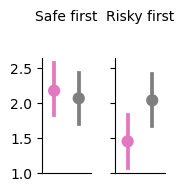

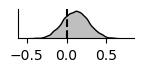

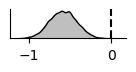

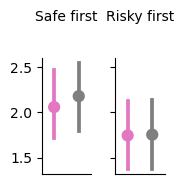

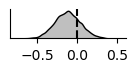

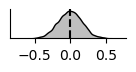

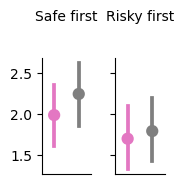

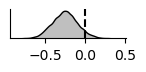

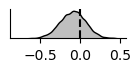

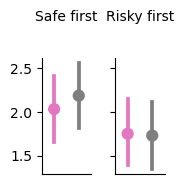

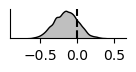

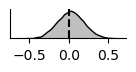

In [167]:
gamma['Order'] = gamma.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
gamma['Subcortical response'] = gamma.index.get_level_values('median_split_subcortical_response')#.map({True:'Large', False:'Small'})


for roi, g in gamma.groupby('roi'):
  print(roi)
  fac = sns.catplot(data=g.reset_index(), x='Subcortical response', y='gamma', col='Order', kind='point', palette=palette,
                     order=['Low activation', 'High activation'],
                    errorbar=get_hdi,
                    col_order=['Safe first', 'Risky first'],
                    aspect=.5, height=1.5*3.2*cm, legend=False)

  fac.set(ylabel=None, xlabel=None, xticks=[])
  fac.set_titles('{col_name}', y=1.25)

  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_roi-{roi}_gamma.pdf', bbox_inches='tight')

  diff1 = (g.xs(False, 0, 'risky_first').xs('Low activation', 0, 'median_split_subcortical_response')['gamma'] - g.xs(False, 0, 'risky_first').xs('High activation', 0, 'median_split_subcortical_response')['gamma']) 

  p = (diff1 > 0.0).mean()
  print(np.min((p, 1-p)))

  plt.figure()
  sns.kdeplot(diff1, fill=True, color='k')
  sns.despine()

  plt.axvline(0.0, c='k', ls='--')
  sns.despine()
  plt.gcf().set_size_inches(1.5, .375)
  plt.xlabel(None)
  plt.ylabel(None)
  plt.yticks([])

  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_roi-{roi}_gamma_safe_first_diff.pdf', bbox_inches='tight')
  # plt.savefig('/data/ds-risk/derivatives/figures/pupil_n1_pre_rnp_safe_first_diff.pdf', bbox_inches='tight')

  plt.figure()
  diff2 = (g.xs(True, 0, 'risky_first').xs('Low activation', 0, 'median_split_subcortical_response')['gamma'] - g.xs(True, 0, 'risky_first').xs('High activation', 0, 'median_split_subcortical_response')['gamma']) 

  p = (diff2 > 0.0).mean()
  print(np.min((p, 1-p)))

  sns.kdeplot(diff2, fill=True, color='k')
  sns.despine()

  plt.axvline(0.0, c='k', ls='--')
  sns.despine()
  plt.gcf().set_size_inches(1.5, .375)
  plt.xlabel(None)
  plt.ylabel(None)
  plt.yticks([])

  p = ((diff1 - diff2) > 0.0).mean()
  print(np.min((p, 1-p)))
  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_roi-{roi}_gamma_risky_first_diff.pdf', bbox_inches='tight')

# Complex model (n_safe x order x median split) 

In [57]:
rois = ['dmidbrain', 'vtav2', 'sncv2', 'meynert', 'lc'][1:]


In [58]:
rnps = []
gammas = []

for roi in rois:
    df, model, idata = load('probit_subcortical_response3', '7t2', roi=roi)
    intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
    rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
    rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

    gamma = gamma.stack([-2, -1])

    rnps.append(rnp)
    gammas.append(gamma)

100%|██████████| 30/30 [00:00<00:00, 32.32it/s]


In [59]:
rnp = pd.concat(rnps, keys=rois, names=['roi'])
gamma = pd.concat(gammas, keys=rois, names=['roi'])

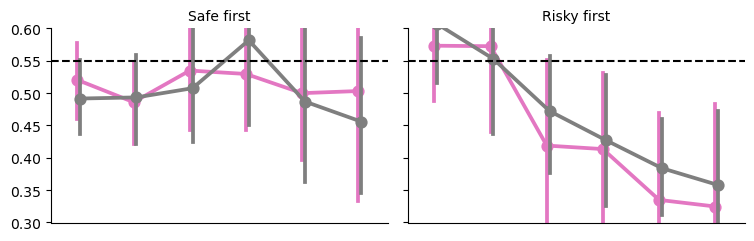

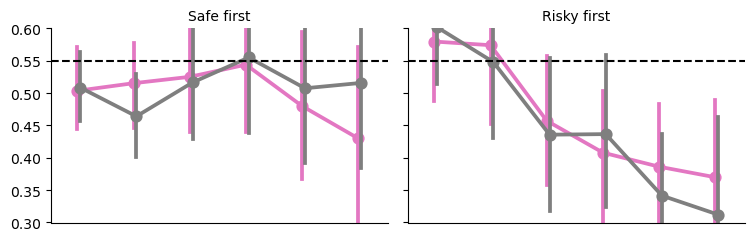

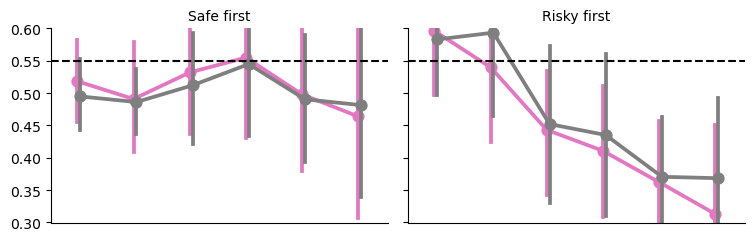

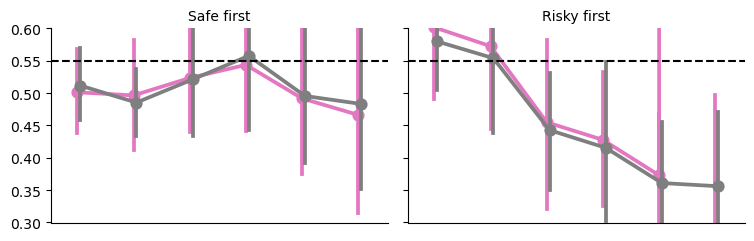

In [60]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Subcortical response'] = rnp.index.get_level_values('median_split_subcortical_response')#.map({True:'Large', False:'Small'})

for roi, r in rnp.groupby('roi'):
  fac = sns.catplot(data=r.reset_index(), x='n_safe', hue='Subcortical response', y='rnp', col='Order', kind='point', palette=palette,
                    hue_order=['Low activation', 'High activation'],
                    dodge=True,
                    errorbar=get_hdi,
                  #   col_order=['Safe first', 'Risky first'],
                    aspect=1.5, height=2*3.2*cm, legend=False)

  fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.3, 0.6))
  fac.set_titles('{col_name}')

  fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


  # plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_complex_n1_prepost_rnp.pdf'), bbox_inches='tight')

## Subjectwise

In [71]:
rnps = []
gammas = []

for roi in rois:
    df, model, idata = load('probit_subcortical_response3', '7t2', roi=roi)
    intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
    rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
    rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)
    rnp = rnp[(rnp['rnp'] > 0.0) & (rnp['rnp'] < 1.0)]

    gamma = gamma.stack([-2, -1])

    rnps.append(rnp)
    gammas.append(gamma)


rnp = pd.concat(rnps, keys=rois, names=['roi'])
gamma = pd.concat(gammas, keys=rois, names=['roi'])

rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Subcortical response'] = rnp.index.get_level_values('median_split_subcortical_response')#.map({True:'Large', False:'Small'})
rnp['distance_to_risk_neutral'] = (rnp['rnp'] - .55).abs()

100%|██████████| 30/30 [00:01<00:00, 28.00it/s]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
100%|██████████| 30/30 [00:00<00:00, 32.56it/s]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
100%|██████████| 30/30 [00:00<00:00, 32.18it/s]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
100%|██████████| 30/30 [00:00<00:00, 31.18it/s]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_4077/519300716.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = r.groupby(['chain', 'draw', 'Subcortical response']).mean()


lc 0.1445


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_4077/519300716.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = r.groupby(['chain', 'draw', 'Subcortical response']).mean()


meynert 0.4705


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_4077/519300716.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = r.groupby(['chain', 'draw', 'Subcortical response']).mean()


sncv2 0.13125
vtav2 0.05325


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_4077/519300716.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = r.groupby(['chain', 'draw', 'Subcortical response']).mean()


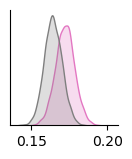

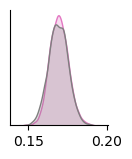

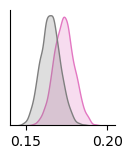

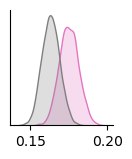

In [78]:
for roi, r in rnp.groupby('roi'):

    tmp = r.groupby(['chain', 'draw', 'Subcortical response']).mean()

    fac = sns.FacetGrid(tmp.reset_index(), hue='Subcortical response', palette=palette,
                       height=1.5*3.2*cm,
                       hue_order=order)
    
    fac.map(sns.kdeplot, 'distance_to_risk_neutral', fill=True)

    fac.set(xlabel=None, ylabel=None, yticks=[])
    split = tmp['distance_to_risk_neutral'].unstack('Subcortical response')
    print(roi, (split[order[0]] < split[order[1]]).mean())
    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-rnp_subcortical_roi-{roi}_rnp_distance.pdf'), bbox_inches='tight')

In [ ]:
1-0.94675

0.05325000000000002

In [ ]:
rnp.groupby(['roi', 'median_split_subcortical_response']).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_4077/2787047461.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rnp.groupby(['roi', 'median_split_subcortical_response']).mean()


rnp  distance_to_risk_neutral
roi     median_split_subcortical_response                                    
lc      High activation                    0.479019                  0.164214
        Low activation                     0.478053                  0.172048
meynert High activation                    0.479184                  0.168905
        Low activation                     0.479358                  0.169425
sncv2   High activation                    0.482926                  0.165006
        Low activation                     0.475330                  0.173317
vtav2   High activation                    0.477159                  0.163132
        Low activation                     0.479438                  0.174942

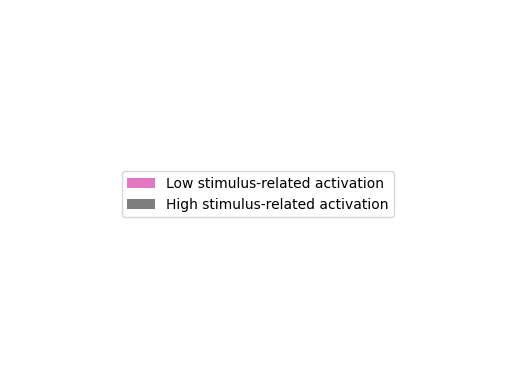

In [12]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


fig = plt.gcf()

legend_elements = [Patch(facecolor=palette[0], label='Low stimulus-related activation'),
                   Patch(facecolor=palette[1], label='High stimulus-related activation') ]


legend = plt.legend(handles=legend_elements, loc='center')
plt.axis('off')

bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig(filename, dpi="figure", bbox_inches=bbox)

plt.savefig('/data/ds-risk/derivatives/figures/subcortical_legend.pdf', bbox_inches=bbox)

# Prestim model

## median split

In [168]:
rois = ['dmidbrain', 'sncv2', 'vtav2', 'lc', 'meynert']
# rois = ['sncv2', 'vtav2', 'meynert', ][:4]

rnps = []
gammas = []

for roi in rois:
    df, model, idata = load('probit_subcortical_prestim_simple.pca', '7t2', roi=roi)
    intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
    rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
    rnp = rnp[(rnp['rnp'] > 0.0) & (rnp['rnp'] < 1.0)]
    rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

    gamma = gamma.stack([-2, -1])

    rnps.append(rnp)
    gammas.append(gamma)

100%|██████████| 30/30 [00:01<00:00, 19.76it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

100%|██████████| 30/30 [00:01<00:00, 24.82it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

100%|██████████| 30/30 [00:01<00:00, 28.96it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

100%|██████████| 30/30 [00:00<00:00, 31.10it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

100%|██████████| 30/30 [00:01<00:00, 24.85it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

In [169]:
rnp = pd.concat(rnps, keys=rois, names=['roi'])
gamma = pd.concat(gammas, keys=rois, names=['roi'])

In [170]:
gamma_1 = gamma.groupby(['roi', 'median_split_subcortical_baseline']).apply(lambda x: pd.Series(get_hdi(x)[0], index=['low', 'up'])).round(2)
gamma_2 = gamma.groupby(['roi', 'median_split_subcortical_baseline']).mean().round(2)
gamma_1.join(gamma_2)[['gamma', 'low', 'up']]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  return tuple(az.hdi(x.values))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  return tuple(az.hdi(x.values))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  return tuple(az.hdi(x.values))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future relea

gamma   low    up
roi       median_split_subcortical_baseline                   
dmidbrain High subcortical activation         1.89  1.57  2.20
          Low subcortical activation          1.87  1.54  2.18
lc        High subcortical activation         1.95  1.65  2.28
          Low subcortical activation          1.81  1.50  2.13
meynert   High subcortical activation         1.81  1.50  2.16
          Low subcortical activation          1.96  1.64  2.28
sncv2     High subcortical activation         1.91  1.60  2.22
          Low subcortical activation          1.87  1.55  2.19
vtav2     High subcortical activation         1.88  1.55  2.19
          Low subcortical activation          1.88  1.55  2.20

dmidbrain rnp    0.181
dtype: float64
lc rnp    0.2295
dtype: float64
meynert rnp    0.76425
dtype: float64
sncv2 rnp    0.399
dtype: float64
vtav2 rnp    0.08725
dtype: float64


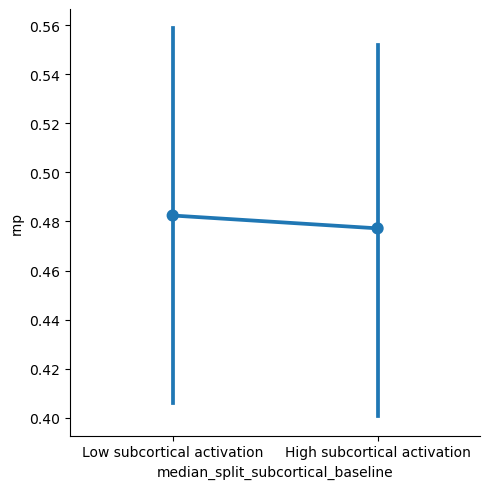

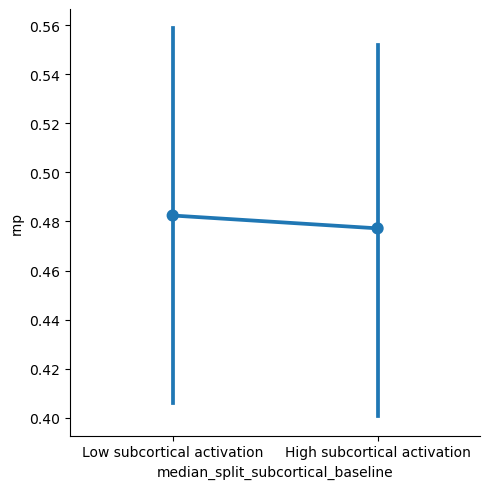

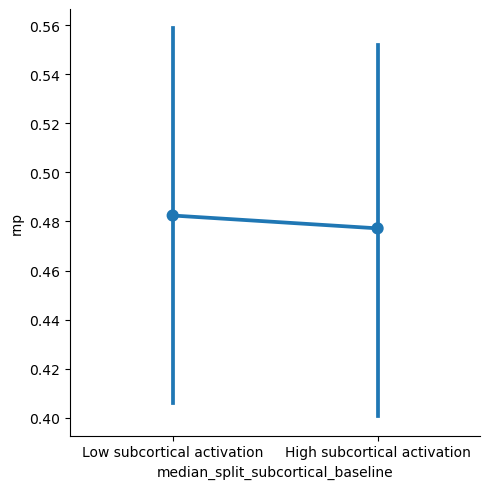

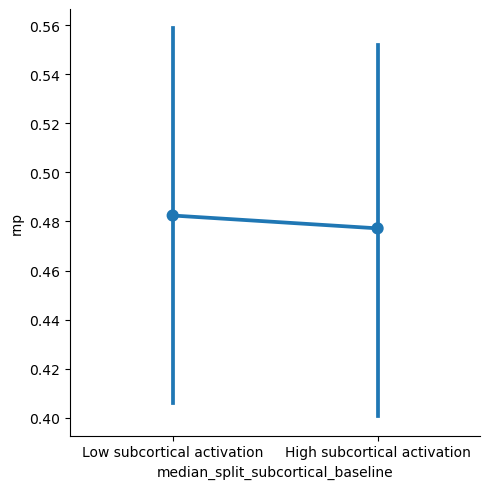

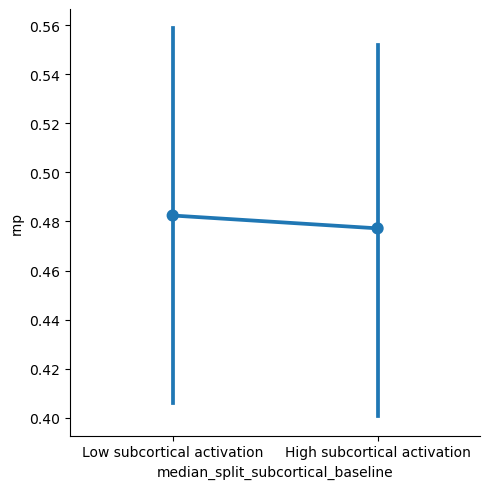

In [175]:
for roi, r in rnp.groupby('roi'):

    sns.catplot(rnp.reset_index(), x='median_split_subcortical_baseline', y='rnp', errorbar=get_hdi, kind='point')

    #   diff2 = (g.xs(True, 0, 'risky_first').xs('Low subcortical activation', 0, 'median_split_subcortical_baseline')['gamma'] - g.xs(True, 0, 'risky_first').xs('High subcortical activation', 0, 'median_split_subcortical_baseline')['gamma']) 
    p = ((r.xs('High subcortical activation', 0, 'median_split_subcortical_baseline') - r.xs('Low subcortical activation', 0, 'median_split_subcortical_baseline') ) > 0.0).mean()

    print(roi, p)

In [172]:
rnp_1 = rnp.groupby(['roi', 'median_split_subcortical_baseline']).apply(lambda x: pd.Series(get_hdi(x)[0], index=['low', 'up'])).round(4)* 100
rnp_2 = rnp.groupby(['roi', 'median_split_subcortical_baseline']).mean().round(4) * 100

rnp_1.join(rnp_2)[['rnp', 'low', 'up']]

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  return tuple(az.hdi(x.values))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  return tuple(az.hdi(x.values))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  return tuple(az.hdi(x.values))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_71512/189316050.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future relea

rnp    low     up
roi       median_split_subcortical_baseline                     
dmidbrain High subcortical activation        47.44  40.09  54.63
          Low subcortical activation         48.36  40.79  55.71
lc        High subcortical activation        47.52  40.58  55.42
          Low subcortical activation         48.34  40.58  56.83
meynert   High subcortical activation        48.43  40.99  56.65
          Low subcortical activation         47.63  40.50  54.99
sncv2     High subcortical activation        47.97  40.42  55.63
          Low subcortical activation         48.24  40.57  55.96
vtav2     High subcortical activation        47.24  40.06  54.74
          Low subcortical activation         48.65  40.78  55.83

dmidbrain gamma    0.5875
dtype: float64
lc gamma    0.89725
dtype: float64
meynert gamma    0.10025
dtype: float64
sncv2 gamma    0.63475
dtype: float64
vtav2 gamma    0.49575
dtype: float64


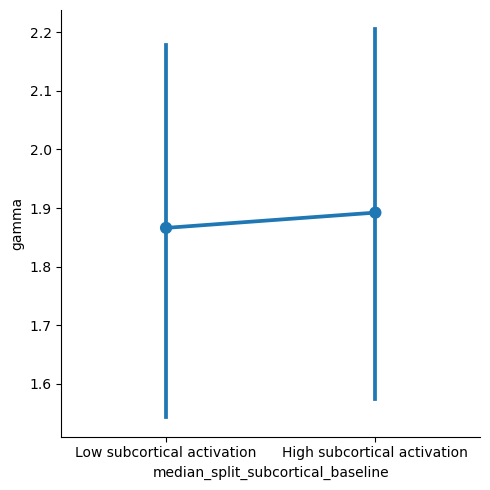

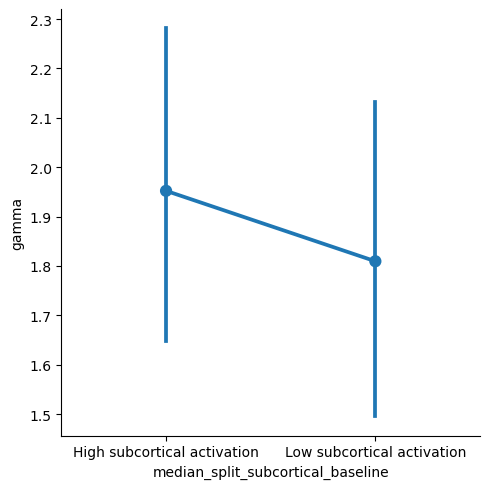

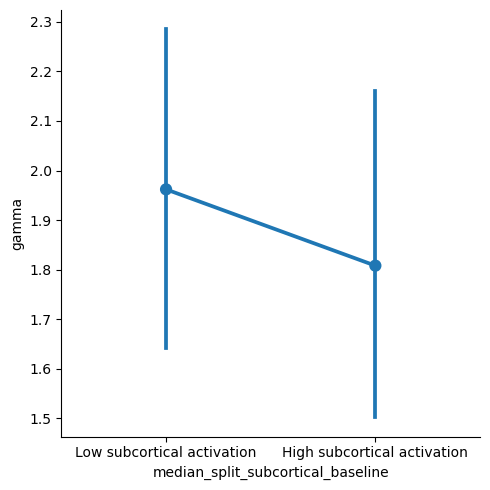

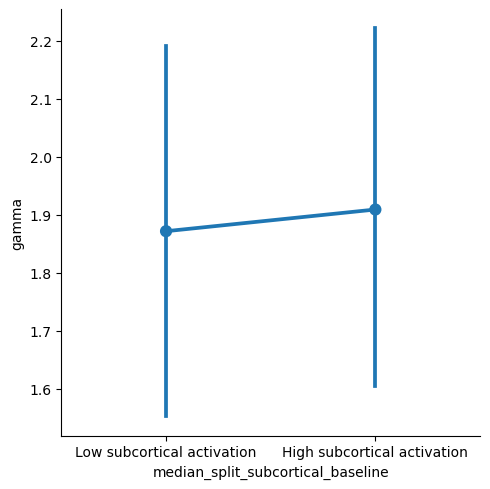

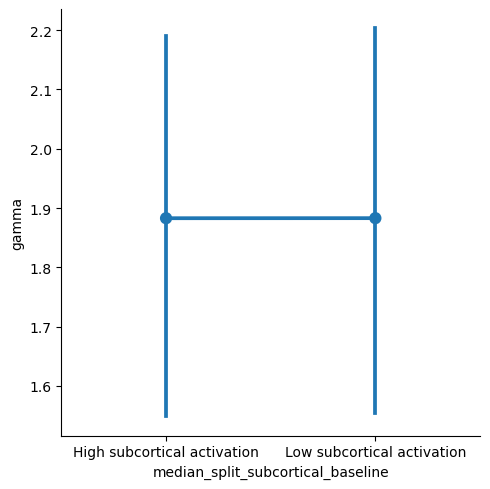

In [173]:
for roi, g in gamma.groupby('roi'):

    sns.catplot(g.reset_index(), x='median_split_subcortical_baseline', y='gamma', errorbar=get_hdi, kind='point')

    #   diff2 = (g.xs(True, 0, 'risky_first').xs('Low subcortical activation', 0, 'median_split_subcortical_baseline')['gamma'] - g.xs(True, 0, 'risky_first').xs('High subcortical activation', 0, 'median_split_subcortical_baseline')['gamma']) 
    p = ((g.xs('High subcortical activation', 0, 'median_split_subcortical_baseline') - g.xs('Low subcortical activation', 0, 'median_split_subcortical_baseline') ) > 0.0).mean()

    print(roi, p)

In [174]:
gamma.groupby(['roi', 'median_split_subcortical_baseline']).mean()

gamma
roi       median_split_subcortical_baseline          
dmidbrain High subcortical activation        1.892257
          Low subcortical activation         1.866211
lc        High subcortical activation        1.952065
          Low subcortical activation         1.809448
meynert   High subcortical activation        1.808227
          Low subcortical activation         1.962108
sncv2     High subcortical activation        1.908814
          Low subcortical activation         1.871459
vtav2     High subcortical activation        1.882790
          Low subcortical activation         1.882891

## risky first x median split

In [146]:
rois = ['sncv2', 'vtav2', 'lc', 'meynert', 'dmidbrain']

rnps = []
gammas = []

for roi in rois:
    df, model, idata = load('probit_subcortical_prestim.pca', '7t2', roi=roi)
    intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
    rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
    rnp = rnp[(rnp['rnp'] > 0.0) & (rnp['rnp'] < 1.0)]
    rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

    gamma = gamma.stack([-2, -1])

    rnps.append(rnp)
    gammas.append(gamma)

100%|██████████| 30/30 [00:01<00:00, 21.86it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

100%|██████████| 30/30 [00:00<00:00, 30.84it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

100%|██████████| 30/30 [00:00<00:00, 30.98it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

100%|██████████| 30/30 [00:00<00:00, 31.52it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

100%|██████████| 30/30 [00:00<00:00, 30.10it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

In [147]:
rnp = pd.concat(rnps, keys=rois, names=['roi'])
gamma = pd.concat(gammas, keys=rois, names=['roi'])

dmidbrain


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


0.45925
0.06574999999999998
0.13425
lc


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


0.36750000000000005
0.18700000000000006
0.295
meynert


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


0.34825
0.2445
0.376
sncv2


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


0.26875
0.20550000000000002
0.13525
vtav2
0.09424999999999994


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


0.49575
0.20375


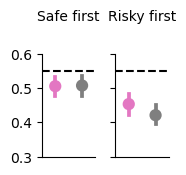

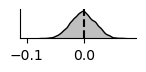

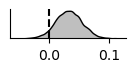

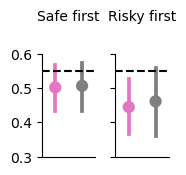

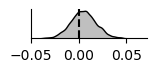

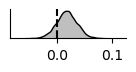

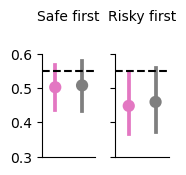

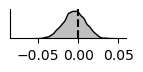

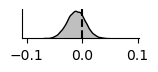

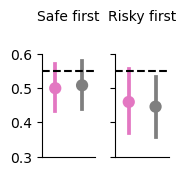

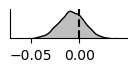

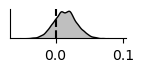

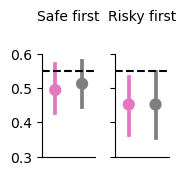

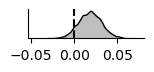

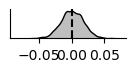

In [148]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Subcortical response'] = rnp.index.get_level_values('median_split_subcortical_baseline')#.map({True:'Large', False:'Small'})


for roi, r in rnp.groupby('roi'):

  print(roi)
  fac = sns.catplot(data=r.reset_index(), x='Subcortical response', y='rnp', col='Order', kind='point', palette=palette,
                    #  order=['Low pupil dilation', 'High pupil dilation'],
                    errorbar=get_hdi,
                    col_order=['Safe first', 'Risky first'],
                    aspect=.5, height=1.5*3.2*cm, legend=False)

  fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.3, 0.6))
  fac.set_titles('{col_name}', y=1.25)
  # fac.set(siptit'{col_name}')
  # fac.fig.suptitle(roi)
  # fac.add_legend()

  fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))

  diff1 = (r.xs(False, 0, 'risky_first').xs('Low subcortical activation', 0, 'median_split_subcortical_baseline')['rnp'] - r.xs(False, 0, 'risky_first').xs('High subcortical activation', 0, 'median_split_subcortical_baseline')['rnp']) 

  p = (diff1 > 0.0).mean()
  print(np.min((p, 1-p)))

  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_prestim_roi-{roi}_rnp.pdf', bbox_inches='tight')

  plt.figure()
  sns.kdeplot(diff1, fill=True, color='k')
  sns.despine()

  plt.axvline(0.0, c='k', ls='--')
  sns.despine()
  plt.xlabel(None)
  plt.ylabel(None)
  plt.yticks([])

  plt.gcf().set_size_inches(1.5, .375)
  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_prestim_roi-{roi}_rnp_safe_first_diff.pdf', bbox_inches='tight')

  plt.figure()
  diff2 = (r.xs(True, 0, 'risky_first').xs('Low subcortical activation', 0, 'median_split_subcortical_baseline')['rnp'] - r.xs(True, 0, 'risky_first').xs('High subcortical activation', 0, 'median_split_subcortical_baseline')['rnp']) 

  p = (diff2 > 0.0).mean()
  print(np.min((p, 1-p)))

  sns.kdeplot(diff2, fill=True, color='k')
  sns.despine()

  plt.axvline(0.0, c='k', ls='--')
  sns.despine()
  plt.xlabel(None)
  plt.ylabel(None)
  plt.yticks([])

  p = ((diff1 - diff2) > 0.0).mean()
  print(np.min((p, 1-p)))

  plt.gcf().set_size_inches(1.5, .375)
  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_prestim_roi-{roi}_rnp_risky_first_diff.pdf', bbox_inches='tight')


    # plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_n1_pre_rnp.pdf'), bbox_inches='tight')

dmidbrain


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


0.4065
0.4625
0.41425
lc


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


0.37
0.04975
0.16974999999999996
meynert


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


0.09624999999999995
0.279
0.31025
sncv2


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


0.46725000000000005
0.28025
0.3225
vtav2


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


0.14675000000000005
0.15975
0.07025000000000003


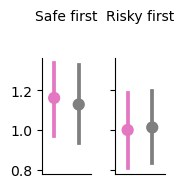

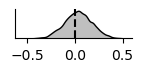

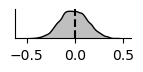

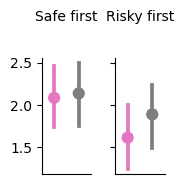

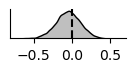

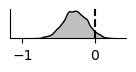

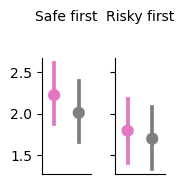

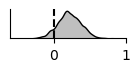

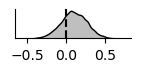

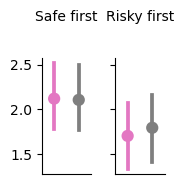

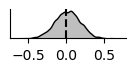

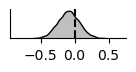

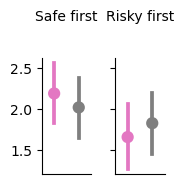

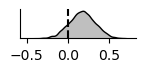

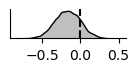

In [149]:
gamma['Order'] = gamma.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
gamma['Subcortical response'] = gamma.index.get_level_values('median_split_subcortical_baseline')#.map({True:'Large', False:'Small'})


for roi, g in gamma.groupby('roi'):
  print(roi)
  fac = sns.catplot(data=g.reset_index(), x='Subcortical response', y='gamma', col='Order', kind='point', palette=palette,
                     order=['Low subcortical activation', 'High subcortical activation'],
                    errorbar=get_hdi,
                    col_order=['Safe first', 'Risky first'],
                    aspect=.5, height=1.5*3.2*cm, legend=False)

  fac.set(ylabel=None, xlabel=None, xticks=[])
  fac.set_titles('{col_name}', y=1.25)

  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_prestim_roi-{roi}_gamma.pdf', bbox_inches='tight')

  diff1 = (g.xs(False, 0, 'risky_first').xs('Low subcortical activation', 0, 'median_split_subcortical_baseline')['gamma'] - g.xs(False, 0, 'risky_first').xs('High subcortical activation', 0, 'median_split_subcortical_baseline')['gamma']) 

  p = (diff1 > 0.0).mean()
  print(np.min((p, 1-p)))

  plt.figure()
  sns.kdeplot(diff1, fill=True, color='k')
  sns.despine()

  plt.axvline(0.0, c='k', ls='--')
  sns.despine()
  plt.gcf().set_size_inches(1.5, .375)
  plt.xlabel(None)
  plt.ylabel(None)
  plt.yticks([])

  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_prestim_roi-{roi}_gamma_safe_first_diff.pdf', bbox_inches='tight')
  # plt.savefig('/data/ds-risk/derivatives/figures/pupil_n1_pre_rnp_safe_first_diff.pdf', bbox_inches='tight')

  plt.figure()
  diff2 = (g.xs(True, 0, 'risky_first').xs('Low subcortical activation', 0, 'median_split_subcortical_baseline')['gamma'] - g.xs(True, 0, 'risky_first').xs('High subcortical activation', 0, 'median_split_subcortical_baseline')['gamma']) 

  p = (diff2 > 0.0).mean()
  print(np.min((p, 1-p)))

  sns.kdeplot(diff2, fill=True, color='k')
  sns.despine()

  plt.axvline(0.0, c='k', ls='--')
  sns.despine()
  plt.gcf().set_size_inches(1.5, .375)
  plt.xlabel(None)
  plt.ylabel(None)
  plt.yticks([])

  p = ((diff1 - diff2) > 0.0).mean()
  print(np.min((p, 1-p)))
  plt.savefig(f'/data/ds-risk/derivatives/figures/subcortical_prestim_roi-{roi}_gamma_risky_first_diff.pdf', bbox_inches='tight')

In [150]:
order = ['Low subcortical activation', 'High subcortical activation']
rnps = []
gammas = []

for roi in rois:
    df, model, idata = load('probit_subcortical_prestim_complex.pca', '7t2', roi=roi)
    intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
    rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
    rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)
    rnp = rnp[(rnp['rnp'] > 0.0) & (rnp['rnp'] < 1.0)]

    gamma = gamma.stack([-2, -1])

    rnps.append(rnp)
    gammas.append(gamma)


rnp = pd.concat(rnps, keys=rois, names=['roi'])
gamma = pd.concat(gammas, keys=rois, names=['roi'])

rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Subcortical response'] = rnp.index.get_level_values('median_split_subcortical_baseline')#.map({True:'Large', False:'Small'})
rnp['distance_to_risk_neutral'] = (rnp['rnp'] - .55).abs()


for roi, r in rnp.groupby('roi'):

    tmp = r.groupby(['chain', 'draw', 'Subcortical response']).mean()

    fac = sns.FacetGrid(tmp.reset_index(), hue='Subcortical response', palette=palette,
                       height=1.5*3.2*cm,
                       hue_order=order)
    
    fac.map(sns.kdeplot, 'distance_to_risk_neutral', fill=True)

    fac.set(xlabel=None, ylabel=None, yticks=[])
    split = tmp['distance_to_risk_neutral'].unstack('Subcortical response')
    print(roi, (split[order[0]] < split[order[1]]).mean())
    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-rnp_subcortical_prestim_roi-{roi}_rnp_distance.pdf'), bbox_inches='tight')

100%|██████████| 30/30 [00:01<00:00, 29.28it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

100%|██████████| 30/30 [00:00<00:00, 31.87it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

100%|██████████| 30/30 [00:00<00:00, 30.66it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

100%|██████████| 30/30 [00:01<00:00, 29.38it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

100%|██████████| 30/30 [00:00<00:00, 31.20it/s]


Running with PCA!
                                    rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob

FileNotFoundError: [Errno 2] No such file or directory: b'/data/ds-risk/derivatives/cogmodels/model-probit_subcortical_prestim_complex.pca_ses-7t2_roi-dmidbrain_trace.netcdf'

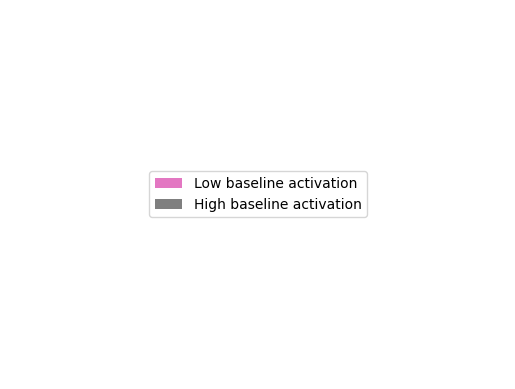

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


fig = plt.gcf()

legend_elements = [Patch(facecolor=palette[0], label='Low baseline activation'),
                   Patch(facecolor=palette[1], label='High baseline activation') ]


legend = plt.legend(handles=legend_elements, loc='center')
plt.axis('off')

bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig(filename, dpi="figure", bbox_inches=bbox)

plt.savefig('/data/ds-risk/derivatives/figures/subcortical_prestim_legend.pdf', bbox_inches=bbox)